In [1]:
! wget https://raw.githubusercontent.com/iknunyants/mlhep2019_2_phase/master/analysis/calogan_metrics.py
! wget https://raw.githubusercontent.com/iknunyants/mlhep2019_2_phase/master/analysis/prd_score.py
! wget https://raw.githubusercontent.com/iknunyants/mlhep2019_2_phase/master/analysis/score.py
! wget https://github.com/iknunyants/mlhep2019_2_phase/raw/master/analysis/embedder.tp

--2020-08-13 08:31:22--  https://raw.githubusercontent.com/iknunyants/mlhep2019_2_phase/master/analysis/calogan_metrics.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4301 (4.2K) [text/plain]
Saving to: ‘calogan_metrics.py’

calogan_metrics.py  100%[===================>]   4.20K  --.-KB/s    in 0s      

2020-08-13 08:31:22 (44.5 MB/s) - ‘calogan_metrics.py’ saved [4301/4301]

--2020-08-13 08:31:25--  https://raw.githubusercontent.com/iknunyants/mlhep2019_2_phase/master/analysis/prd_score.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Lengt

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as utils
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm, tqdm_notebook
import seaborn as sns
from IPython.display import clear_output
from torchsummary import summary

sns.set()


def one_hot(a, num_classes):
    return np.squeeze(np.eye(num_classes)[a.reshape(-1)])


device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Available device =", device)


Available device = cuda


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_energy_and_shower(energ_distr_real, energ_distr_generated):
    f, ax = plt.subplots(2,2, figsize=(8, 8))
    #f.suptitle("Energy distribution", fontsize=16, y=.9)

    vmin = torch.max(energ_distr_real) 
    vmin = min(vmin, torch.min(energ_distr_generated))
    vmax = torch.max(energ_distr_real) 
    vmax = max(vmax, torch.max(energ_distr_generated))

    for i, distr_type, en_dep in zip([0,1], ["Real", "Generated"],
                                [energ_distr_real[0], energ_distr_generated[0]]):
        for j, distr_name in zip([0,1], ["energy distribution", "shower"]):
            ax[j][i].set_title (distr_type + " " + distr_name,  fontsize=14)
            ax[j][i].set_xticks(np.arange(-0.5, 30., 1.), minor=True)
            ax[j][i].set_xticks(np.arange(-0.5, 30., 5.), minor=False)                    
            ax[j][i].set_xticklabels(np.arange(-15, 16, 5), minor=False, fontsize=8)

        ax[0][i].set_xlabel(r'$x$', fontsize=12)
        ax[0][i].set_ylabel(r'$y$', fontsize=12)
        ax[1][i].set_xlabel(r'Cluster traverse width ($x$)', fontsize=12)
        ax[1][i].set_ylabel(r'Arbitrary units (sum along $y$)', fontsize=12)

        ax[0][i].set_yticks(np.arange(-0.5, 30., 1.), minor=True)
        ax[0][i].set_yticks(np.arange(-0.5, 30., 5.), minor=False)                    
        ax[0][i].set_yticklabels(np.arange(-15, 16, 5), minor=False, fontsize=8)

        # plot shower
        ax[1][i].bar(np.arange(0,30), torch.sum(en_dep, axis=0), 
                  width=1.0, align='edge', edgecolor='black')

        # plot energy distribution
        ax[0][i].grid(which='both', color='dimgray', linestyle='-', linewidth=0.5)
        im = ax[0][i].imshow(en_dep, origin = 'lower', cmap="inferno", 
                          vmin=vmin, vmax=vmax)

        # add colorabar for the energy distributions
        divider = make_axes_locatable(ax[0][i])
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im, cax=cax)

    plt.subplots_adjust(wspace=0.4, hspace=0.4)
    plt.show()
    return

In [4]:
from google.colab import drive

drive.mount('/gdrive')

train_data_path = '/gdrive/My Drive/mlhep2019_vae/data_train.npz'
val_data_path = '/gdrive/My Drive/mlhep2019_vae/data_val.npz'
test_data_path = '/gdrive/My Drive/mlhep2019_vae/data_test.npz'


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


In [5]:
from sklearn.model_selection import train_test_split 

data_train = np.load(train_data_path, allow_pickle=True)
data_test = np.load(test_data_path, allow_pickle=True)

# N = 10000
# data_train = data[0:N]

EnergyDeposit, EnergyDepositTest, ParticleMomentum, ParticleMomentumTest, ParticlePoint, ParticlePointTest = train_test_split(data_train['EnergyDeposit'].reshape(-1, 1, 30, 30), 
                                                                                                                              data_train['ParticleMomentum'], data_train['ParticlePoint'][:, :2], test_size = 0.1, train_size = 0.9)

EnergyDeposit = torch.tensor(EnergyDeposit).float()
ParticleMomentum = torch.tensor(ParticleMomentum).float()
ParticlePoint = torch.tensor(ParticlePoint).float()
EnergyDepositTest = torch.tensor(EnergyDepositTest).float()
ParticleMomentumTest = torch.tensor(ParticleMomentumTest).float()
ParticlePointTest = torch.tensor(ParticlePointTest).float()


In [6]:
BATCH_SIZE = 1024

calo_dataset = utils.TensorDataset(EnergyDeposit, ParticleMomentum, ParticlePoint)
calo_dataloader = torch.utils.data.DataLoader(calo_dataset, batch_size=BATCH_SIZE, pin_memory=True, shuffle=True)

calo_dataset_test = utils.TensorDataset(EnergyDepositTest, ParticleMomentumTest, ParticlePointTest)
calo_dataloader_test = torch.utils.data.DataLoader(calo_dataset_test, batch_size=BATCH_SIZE, pin_memory=True, shuffle=True)

# Building model

In [7]:
LATENT_DIM = 16

In [8]:
SHOW_PICS = 10
IMAGES_SHOW = np.random.randint(len(calo_dataloader_test.dataset), size=SHOW_PICS)

In [9]:
class VAE(nn.Module):
    def __init__(self, z_dim=LATENT_DIM, en_activation=F.leaky_relu, dec_activation=F.relu):
        super(VAE, self).__init__()
        
        self.en_activ = en_activation
        self.dec_activ = dec_activation

        self.conv1 = nn.Conv2d( 1,   32, 3, stride=2, padding=1)
        self.conv2 = nn.Conv2d( 32,  64, 3, stride=2, padding=0)
        self.conv3 = nn.Conv2d( 64, 128, 3, stride=2, padding=0)
        self.conv4 = nn.Conv2d(128, 256, 3, stride=2, padding=0)
        self.conv5 = nn.Conv2d(256, 256, 3, stride=2, padding=0)

        self.fc1 = nn.Linear(256 + 5, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3a = nn.Linear(64, z_dim)
        self.fc3b = nn.Linear(64, z_dim)

        self.fc1t = nn.Linear(z_dim + 5, z_dim * 2 * 2)
        self.fc2t = nn.Linear(z_dim * 2 * 2, z_dim * 2 * 2 * 4)
        self.fc3t = nn.Linear(z_dim * 2 * 2 * 4, z_dim * 2 * 2 * 8)


        # (Z x 8) x 2 x 2
        self.conv1t = nn.ConvTranspose2d(z_dim * 8, 128, 3, stride=2, padding=1, output_padding=1) 
        # 128 x 8 x 8
        self.conv2t = nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1)
        # 64 x 16 x 16
        self.conv3t = nn.ConvTranspose2d(64, 32,  3, stride=2, padding=1, output_padding=1)
        # 32 x 32 x 32
        self.conv4t = nn.ConvTranspose2d(32, 1,  3, stride=2, padding=1, output_padding=1)
        # 1 x 32 x 32
        # crop
        # 1 x 30 x 30

        self.bn1 = nn.BatchNorm2d(128)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(32)

    def encode(self, X, params):
        X = self.en_activ(self.conv1(X))
        X = self.en_activ(self.conv2(X))
        X = self.en_activ(self.conv3(X))
        X = self.en_activ(self.conv4(X))

        X = X.reshape(-1,256)
        X = torch.cat([X, params], dim=1)
        X = self.en_activ(self.fc1(X))
        X = self.en_activ(self.fc2(X))
        return self.en_activ(self.fc3a(X)), self.en_activ(self.fc3b(X))

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, params):
        z = self.en_activ(self.fc1t(torch.cat([z, params], dim=1)))
        z = self.en_activ(self.fc2t(z))
        z = self.en_activ(self.fc3t(z))
        z = z.view(-1, LATENT_DIM * 8, 2, 2)

        z = self.dec_activ(self.bn1(self.conv1t(z)))
        #print(EnergyDeposit.shape)
        z = self.dec_activ(self.bn2(self.conv2t(z)))
        #print(EnergyDeposit.shape)
        z = self.dec_activ(self.bn3(self.conv3t(z)))
        #print(EnergyDeposit.shape)
        z = self.dec_activ(self.conv4t(z))
        
        z = z[:,:,1:31,1:31]
        return z

    def forward(self, x, params):
        mu, logvar = self.encode(x, params)
        z = self.reparameterize(mu, logvar)
        return self.decode(z, params), mu, logvar

In [10]:
# model1 = VAE().to(device)
# sum = 0
# for p, n in zip(model1.parameters(), model1.named_parameters()):
#     sum += p.numel()
#     print(n[0], p.numel())
# print("Total param size: ", sum)

In [11]:
# BETA = 0.2
# BETA = 1e-1
BETA = 5.

In [12]:
def loss_function(recon_x, x, mu, logvar):
    RMSE = torch.sqrt(F.mse_loss(recon_x, x, reduction='sum'))
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return RMSE + KLD, RMSE.item(), KLD.item()

In [13]:
# def loss_function(recon_x, x, mu, logvar):
#     RMSE = torch.sqrt(F.mse_loss(recon_x, x, reduction='sum'))
#     KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
#     return RMSE + BETA * KLD, RMSE.item(), KLD.item()

In [14]:
# def loss_function(recon_x, x, mu, logvar):
#     MSE = F.mse_loss(recon_x, x, reduction='sum')
#     KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
#     return MSE + KLD, MSE.item(), KLD.item()

# Plotting functions

In [15]:
def plot_energy_and_shower(energ_distr_real, energ_distr_generated):
    f, ax = plt.subplots(2,2, figsize=(8, 8))
    #f.suptitle("Energy distribution", fontsize=16, y=.9)

    vmin = torch.max(energ_distr_real) 
    vmin = min(vmin, torch.min(energ_distr_generated))
    vmax = torch.max(energ_distr_real) 
    vmax = max(vmax, torch.max(energ_distr_generated))

    for i, distr_type, en_dep in zip([0,1], ["Real", "Generated"],
                                [energ_distr_real[0], energ_distr_generated[0]]):
        for j, distr_name in zip([0,1], ["energy distribution", "shower"]):
            ax[j][i].set_title (distr_type + " " + distr_name,  fontsize=14)
            ax[j][i].set_xticks(np.arange(-0.5, 30., 1.), minor=True)
            ax[j][i].set_xticks(np.arange(-0.5, 30., 5.), minor=False)                    
            ax[j][i].set_xticklabels(np.arange(-15, 16, 5), minor=False, fontsize=10)

        ax[0][i].set_xlabel(r'$x$', fontsize=12)
        ax[0][i].set_ylabel(r'$y$', fontsize=12)
        ax[1][i].set_xlabel(r'Cluster traverse width ($x$)', fontsize=12)
        ax[1][i].set_ylabel(r'Arbitrary units (sum along $y$)', fontsize=12)

        ax[0][i].set_yticks(np.arange(-0.5, 30., 1.), minor=True)
        ax[0][i].set_yticks(np.arange(-0.5, 30., 5.), minor=False)                    
        ax[0][i].set_yticklabels(np.arange(-15, 16, 5), minor=False, fontsize=10)

        # plot shower
        ax[1][i].bar(np.arange(0,30), torch.sum(en_dep, axis=0), 
                  width=1.0, align='edge', edgecolor='black')

        # plot energy distribution
        ax[0][i].grid(which='both', color='dimgray', linestyle='-', linewidth=0.5)
        im = ax[0][i].imshow(en_dep, origin = 'lower', cmap="inferno", 
                          vmin=vmin)#, vmax=vmax)

        # add colorabar for the energy distributions
        divider = make_axes_locatable(ax[0][i])
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im, cax=cax)

    plt.subplots_adjust(wspace=0.4, hspace=0.4)
    #plt.show()
    return

In [16]:
def plot_epoch(epoch, init_pics, gen_pics, recon_pics, kl_train, kl_test, rmse_train, rmse_test, loss_train, loss_test, prd_auc_train, prd_auc_test):

    clear_output()

    fs_title = 14
    fs_axis = 12
    fs_ticks = 10

    f, ax = plt.subplots(2,2, figsize=(15, 15))

    ax[0][0].set_title ('Overall loss', fontsize=fs_title)
    ax[0][0].set_xlabel('Epoch',     fontsize=fs_axis)
    ax[0][0].set_ylabel('Loss',          fontsize=fs_axis)
    
    ax[0][0].set_xticks     (np.linspace(0.0, len(loss_test), 5))
    ax[0][0].set_xticklabels(np.linspace(0.0, epoch, 5))
    ax[0][0].plot(loss_train, label='train', color = 'red',  alpha=0.5)
    ax[0][0].plot(loss_test, label='test',     color = 'blue', alpha=0.5)
    ax[0][0].legend()

    ax[0][1].set_title ('KL divergence', fontsize=fs_title)
    ax[0][1].set_xlabel('Epoch',     fontsize=fs_axis)
    ax[0][1].set_ylabel('Loss',          fontsize=fs_axis)
    
    ax[0][1].set_xticks     (np.linspace(0.0, len(kl_train), 5))
    ax[0][1].set_xticklabels(np.linspace(0.0, epoch, 5))
    ax[0][1].plot(kl_train, label='train', color = 'red',  alpha=0.5)
    ax[0][1].plot(kl_test, label='test',     color = 'blue', alpha=0.5)
    ax[0][1].legend()

    ax[1][0].set_title ('Recon loss', fontsize=fs_title)
    ax[1][0].set_xlabel('Epoch',     fontsize=fs_axis)
    ax[1][0].set_ylabel('Loss',          fontsize=fs_axis)
    
    ax[1][0].set_xticks     (np.linspace(0.0, len(rmse_train), 5))
    ax[1][0].set_xticklabels(np.linspace(0.0, epoch, 5))
    ax[1][0].plot(rmse_train, label='train', color = 'red',  alpha=0.5)
    ax[1][0].plot(rmse_test, label='test',     color = 'blue', alpha=0.5)
    ax[1][0].legend()
    
    ax[1][1].set_xticks     (np.linspace(0.0, epoch, 5))
    ax[1][1].set_xticklabels(np.linspace(0.0, epoch, 5))
    ax[1][1].set_title ('PRD AUC', fontsize=fs_title)
    ax[1][1].set_xlabel('Epoch',   fontsize=fs_axis)
    ax[1][1].set_ylabel('PRD AUC', fontsize=fs_axis)
    ax[1][1].plot(prd_auc_train,     label="Training",  color='red')
    ax[1][1].plot(prd_auc_test, label="Test", color='blue')
    ax[1][1].legend()
    for i in range(len(init_pics)):
        plot_energy_and_shower(init_pics.detach().cpu()[i], gen_pics.detach().cpu()[i])
    plt.show()
    return

# Training function

In [17]:
CALC_PRD = 50                
NUM_RUNS = 10

In [18]:
from calogan_metrics import get_physical_stats

def prd_auc(generated_example, real_example, reshape_size, ParticleMomentum_b, ParticlePoint_b):
    
    # real_example = real_example[:CALC_PRD]
    # generated_example = generated_example[:CALC_PRD]
    # ParticleMomentum_b = ParticleMomentum_b[:CALC_PRD]
    # ParticlePoint_b = ParticlePoint_b[:CALC_PRD]

    precision, recall = compute_prd_from_embedding(
                        real_example.reshape(len(real_example), -1), 
                        generated_example.reshape(len(generated_example), -1),
                        num_clusters=100,
                        num_runs=NUM_RUNS)
    
    auc_img = auc(precision, recall)
    
    physical_metrics_sol = get_physical_stats(
        real_example.reshape(-1, 30, 30), 
        ParticleMomentum_b,
        ParticlePoint_b)
    
    physical_metrics_pred = get_physical_stats(
        generated_example.reshape(-1, 30, 30), 
        ParticleMomentum_b,
        ParticlePoint_b)

    precision, recall = compute_prd_from_embedding(
        physical_metrics_sol, 
        physical_metrics_pred,
        num_clusters=100,
        num_runs=NUM_RUNS)
    
    auc_physical_metrics = auc(precision, recall)

    return min(auc_img, auc_physical_metrics)

In [19]:
PRD_FREQ = 1

In [20]:
from prd_score import compute_prd, compute_prd_from_embedding, _prd_to_f_beta
from sklearn.metrics import auc

def run_training(epochs):
    current_epoch = 0
    kl_train = []
    rmse_train = []
    loss_train = []
    prd_auc_train = []
    kl_test = []
    rmse_test = []
    loss_test = []
    prd_auc_test = []
    for epoch in tqdm(np.arange(current_epoch, epochs)):
        model.train()
        epoch_loss = 0
        kl_loss = 0
        rmse_loss = 0
        first = True
        for EnergyDeposit_b, ParticleMomentum_b, ParticlePoint_b in calo_dataloader:
            EnergyDeposit_b, ParticleMomentum_b, ParticlePoint_b = EnergyDeposit_b.to(device), \
                ParticleMomentum_b.to(device), \
                ParticlePoint_b.to(device)
            ParticleMomentum_ParticlePoint_b = torch.cat([ParticleMomentum_b, ParticlePoint_b], dim=1)
            data = EnergyDeposit_b  # , ParticleMomentum_ParticlePoint_b], dim=1)
            # for batch_idx, (data, _) in enumerate(train_loader):
            recon_batch, mu, logvar = model(data, ParticleMomentum_ParticlePoint_b)
            loss, rmse, kl = loss_function(recon_batch, EnergyDeposit_b, mu, logvar)
            optimizer.zero_grad()
            loss.backward()
            kl_loss += kl
            rmse_loss += rmse
            epoch_loss += loss.item()
            
            optimizer.step()
            
            if first and current_epoch != 0 and current_epoch % PRD_FREQ == 0:
                noise = torch.tensor(np.random.normal(0,1,size=(len(ParticleMomentum_ParticlePoint_b), LATENT_DIM))).float().to(device)
                recon_batch = model.decode(noise, ParticleMomentum_ParticlePoint_b).detach().cpu().numpy()
                reshape_size = EnergyDeposit_b.shape[0] # = BATCH_SIZE or less
                prd_auc_train.append(prd_auc(recon_batch, EnergyDeposit_b.detach().cpu().numpy(), reshape_size, ParticleMomentum_b.detach().cpu().numpy(), ParticlePoint_b.detach().cpu().numpy()))
                first = False
        
        
        if current_epoch != 0:
            kl_train.append(kl_loss / len(calo_dataloader.dataset))
            rmse_train.append(rmse_loss / len(calo_dataloader.dataset))
            loss_train.append(epoch_loss / len(calo_dataloader.dataset))
    
        model.eval()
        epoch_loss = 0
        kl_loss = 0
        rmse_loss = 0
        first = True
        with torch.no_grad():
            for EnergyDeposit_b, ParticleMomentum_b, ParticlePoint_b in calo_dataloader_test:
                EnergyDeposit_b, ParticleMomentum_b, ParticlePoint_b = EnergyDeposit_b.to(device), \
                    ParticleMomentum_b.to(device), \
                    ParticlePoint_b.to(device)
                ParticleMomentum_ParticlePoint_b = torch.cat([ParticleMomentum_b, ParticlePoint_b], dim=1)
                data = EnergyDeposit_b  # , ParticleMomentum_ParticlePoint_b], dim=1)
                # for batch_idx, (data, _) in enumerate(train_loader):
                recon_batch, mu, logvar = model(data, ParticleMomentum_ParticlePoint_b)
                loss, rmse, kl = loss_function(recon_batch, EnergyDeposit_b, mu, logvar)
                kl_loss += kl
                rmse_loss += rmse
                epoch_loss += loss.item()
                
                if first and current_epoch != 0 and current_epoch % PRD_FREQ == 0:
                    noise = torch.tensor(np.random.normal(0,1,size=(len(ParticleMomentum_ParticlePoint_b), LATENT_DIM))).float().to(device)
                    recon_batch = model.decode(noise, ParticleMomentum_ParticlePoint_b).detach().cpu().numpy()
                    reshape_size = EnergyDeposit_b.shape[0] # = BATCH_SIZE or less
                    prd_auc_test.append(prd_auc(recon_batch, EnergyDeposit_b.detach().cpu().numpy(), reshape_size, ParticleMomentum_b.detach().cpu().numpy(), ParticlePoint_b.detach().cpu().numpy()))
                    first = False
                
            EnergyDeposit_b, ParticleMomentum_b, ParticlePoint_b = calo_dataloader_test.dataset[IMAGES_SHOW]
            EnergyDeposit_b, ParticleMomentum_b, ParticlePoint_b = EnergyDeposit_b.to(device).reshape((-1,1,30,30)), \
                                                                    ParticleMomentum_b.to(device).reshape((-1,3)), \
                                                                    ParticlePoint_b.to(device).reshape((-1,2))
            ParticleMomentum_ParticlePoint_b = torch.cat([ParticleMomentum_b, ParticlePoint_b], dim=1)
            init_pics = EnergyDeposit_b
            recon_pics,_ ,_ = model(EnergyDeposit_b, ParticleMomentum_ParticlePoint_b)
            noise = torch.tensor(np.random.normal(0,1,size=(len(ParticleMomentum_ParticlePoint_b), LATENT_DIM))).float().to(device)
            gen_pics = model.decode(noise, ParticleMomentum_ParticlePoint_b)


        
        if current_epoch != 0:
            kl_test.append(kl_loss / len(calo_dataloader_test.dataset))
            rmse_test.append(rmse_loss / len(calo_dataloader_test.dataset))
            loss_test.append(epoch_loss / len(calo_dataloader_test.dataset))
        if current_epoch % 2 == 0:
            plot_epoch(current_epoch, init_pics, gen_pics.reshape((-1, 1, 30, 30)), recon_pics, kl_train, kl_test, rmse_train, rmse_test, loss_train, loss_test, prd_auc_train, prd_auc_test)

        current_epoch += 1

    return

# Training

In [21]:
EPOCHS = 30

In [46]:
learning_rate = 0.0005
# wd = 1e-6
model = VAE().to(device)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)#, weight_decay=wd)
#summary(model, [(1, 30, 30), [5]])

In [47]:
model = VAE().to(device)
model.load_state_dict(torch.load('/gdrive/My Drive/mlhep2019_vae/vae.pt'))

<All keys matched successfully>

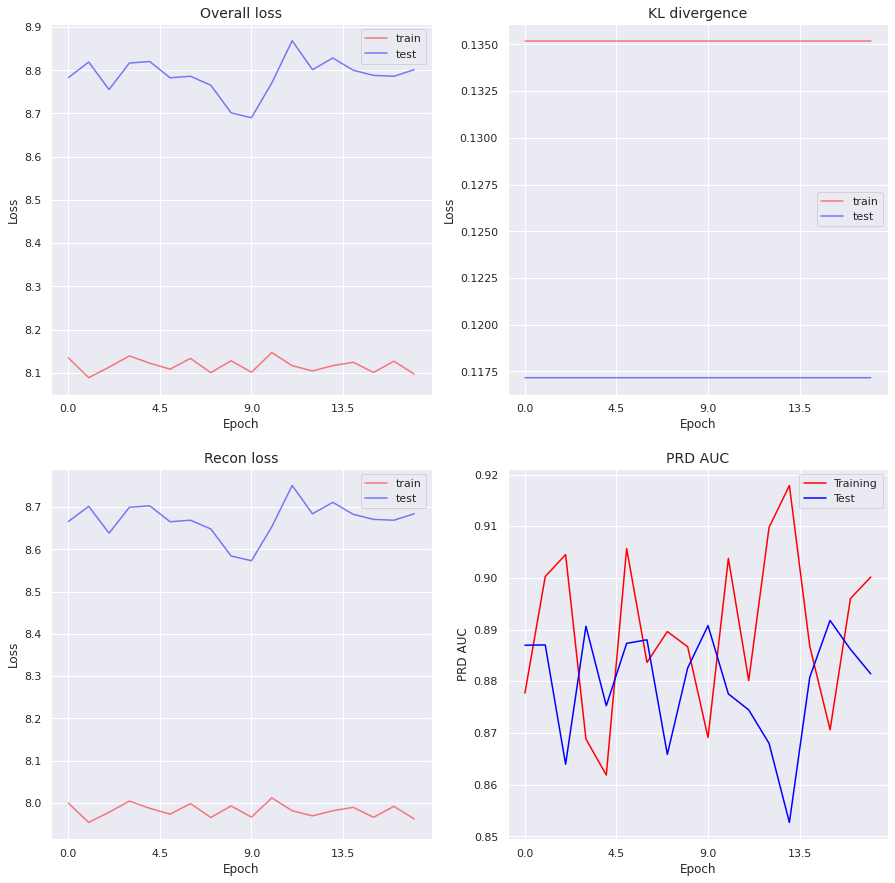

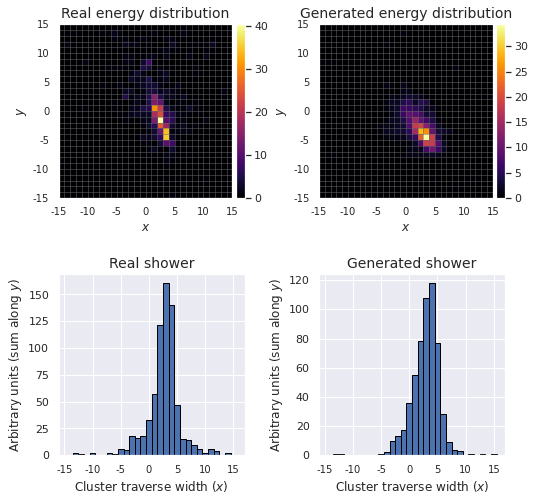

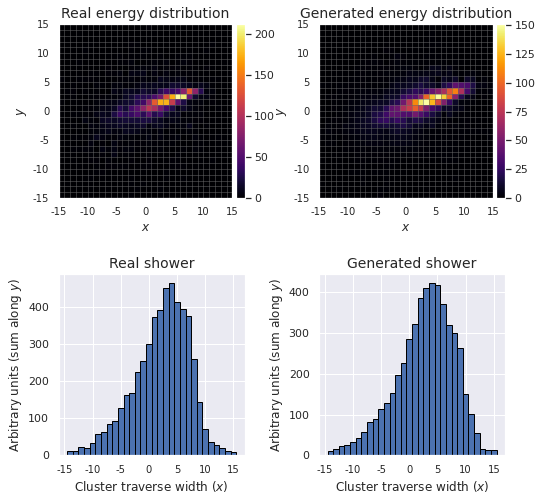

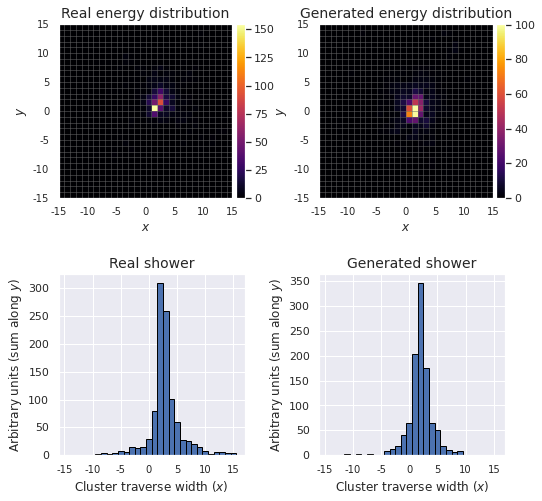

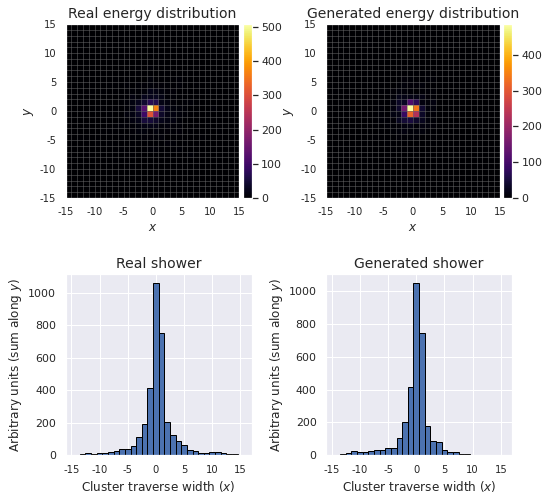

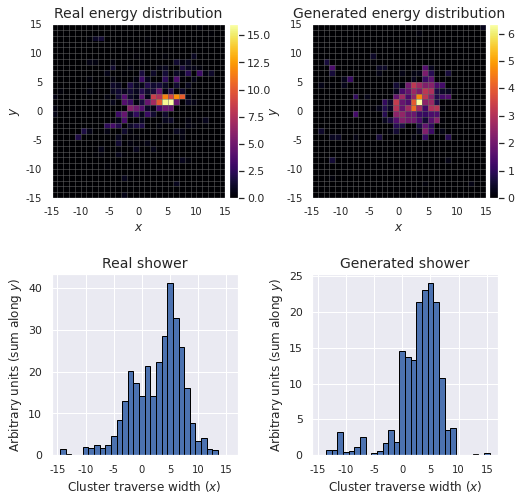

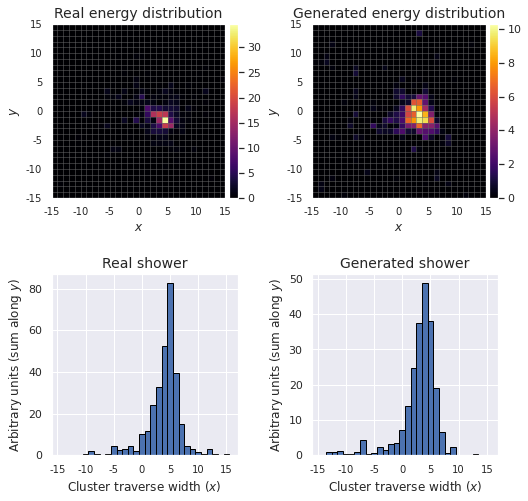

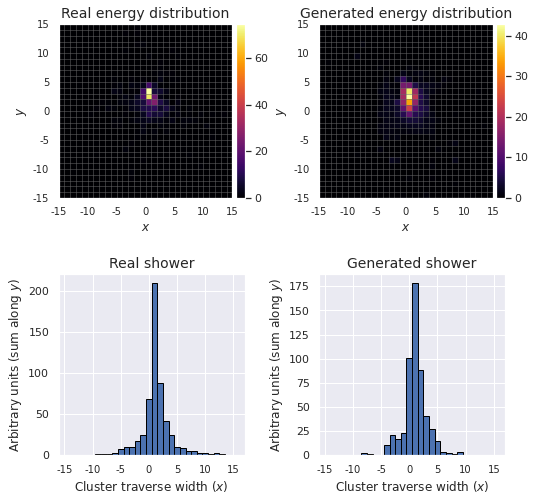

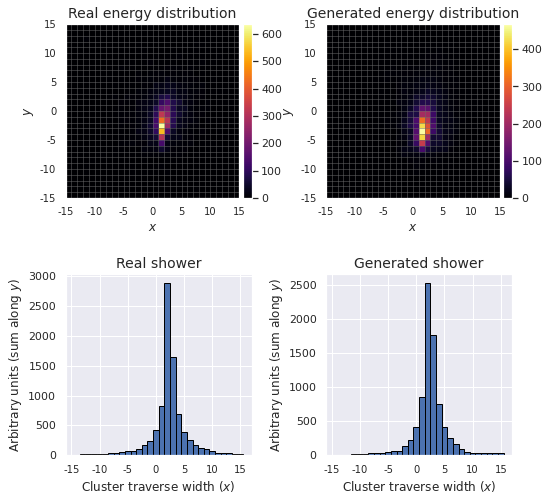

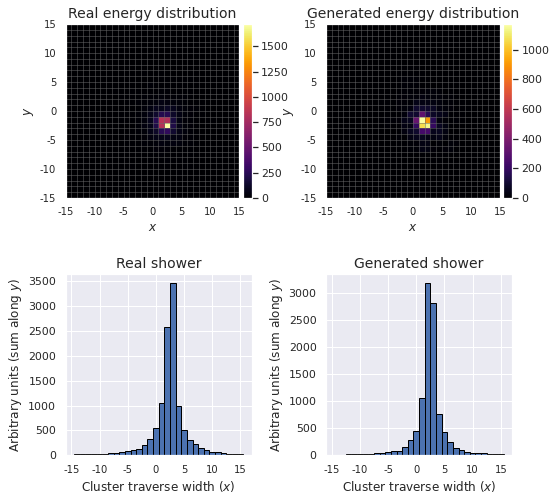

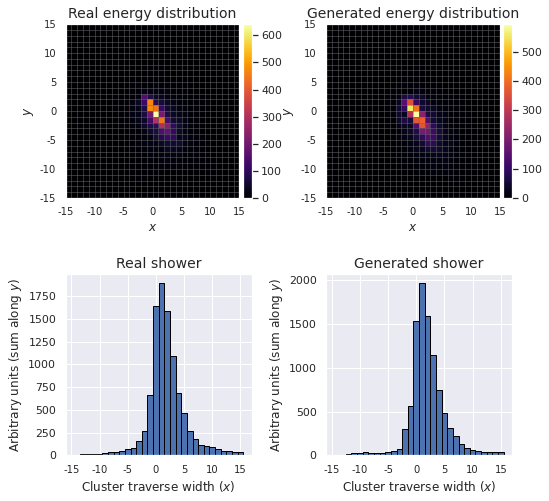








 63%|██████▎   | 19/30 [30:36<18:27, 100.65s/it]






 67%|██████▋   | 20/30 [32:04<16:09, 96.92s/it] 

KeyboardInterrupt: ignored

In [48]:
run_training(EPOCHS)

In [33]:
torch.save(model.state_dict(), '/gdrive/My Drive/mlhep2019_vae/vae.pt')